# <center>The Blattle of Neighborhoods in Santiago, Chile

<center>Patricia Avaroma
    
<center>November 26, 2020

Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction](#Introduction)
* [Data source and usage](#Data)
* [Data gathering and wrangling](#Wrangling)
* [Methodology and exploratory data analysis](#Methodology)
* [Clustering model](#Model)
* [Results and discussion](#Results)
* [Conclusion](#Conclusion)

## 1. Introduction <a name="Introduction"></a>

### Background
When you must move to a new city for many people it is an amazing stage of life but stressful as well. Should you look for something near to your new job, school, or university? or may be look for quality life, or price, or a mix of everything? 
Therefore, it is beneficial to have segmented the city considering a series of features and let future residents to take their decision of leaving in an easier way, limiting some scopes regarding the features.

### Problem - Objective
This project aims to cluster the city of Santiago considering the top 10 neighborhoods with the best Urban Quality life’s Index to show some options to future residents, and I will explain what distinguishes each cluster.

### Stakeholders
Families, workers, or students would be interested in this segmentation to better take the decision of moving related to their interests.

## 2. Data source and usage <a name="Data"></a>
To resolve the problem, we need information about:
-	Types of venues around the neighborhoods of the city of Santiago, like restaurants, health venues, parks, schools, universities, and so on.
-	The most recent ranking with the Urban Quality Life’s Index of the city of Santiago.
-	The home purchase and rental prices to complement the features to be analyzed (in UF, “Unidad de Fomento”, and indexed unit of account).
The source for venues is Foursquare location data, and for the Index and prices I decided to scrap the data from public Chilean newspapers with official information.

## 3. Data gathering and wrangling  <a name="Wrangling"></a>

Before we start with the data, we have to download all the libraries that will work for the project.

In [1]:
import numpy as np
import pandas as pd 
!pip install matplotlib
from matplotlib import pyplot as plt

import json #to handle JSON files
from geopy.geocoders import Nominatim # to convert an address into latitude and longitude values
from bs4 import BeautifulSoup
import requests
from pandas.io.json import json_normalize # to tranform JSON file into a pandas dataframe

# Matplotlib and plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# Models
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN 
from sklearn.datasets.samples_generator import make_blobs 
from sklearn.preprocessing import StandardScaler 
import sklearn.utils

#Visualization
!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Libraries imported.')

In C:\Users\Patty\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Patty\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Patty\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Patty\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Patty\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


Before we start to gather all the information, it is important to mention the political division of Chile for a better understanding of the scope in this project.

For the government and the internal state management, Chile is divided into 16 regions, which at the same time are divided in 56 provinces. For local management, the provinces are divided into 346 Comunas. Given that in Santiago the people take home living decision from Comunas, this will be the definition of Neighborhoods for this project. 

By the effect of this project we will focus to take a look to the province of Santiago in the “Región Metropolitana (Metropolitan Region)”, that is the capital of Chile. Santiago has 32 Neighborhoods.

In [2]:
# Getting the html to scrape the summary
url_stgo = "https://es.wikipedia.org/wiki/Regi%C3%B3n_Metropolitana_de_Santiago"
results = requests.get(url_stgo)
soup = BeautifulSoup(results.content, "lxml")

# Getting the table
table = soup.find_all("table", {"class":"wikitable"})
df_t = pd.read_html(str(table))
comunas = pd.DataFrame(df_t[0])

# Filtering "Santiago"
comunas_rm = comunas.copy()
comunas_rm = comunas_rm["Capital"]=="Santiago"
rm_ = comunas[comunas_rm].reset_index(drop=True)
rm_.head()

# Splitting Comuna to delate the number and show only name.
rm = rm_.copy()
rm[["n", "Comuna_"]]=rm["Comuna"].str.split(" ", n=1, expand=True)
rm=rm.drop("Comuna", 1)
rm=rm.drop("n", 1)
rm.rename(columns={"Comuna_":"Neighborhood", "Provincia":"Province"}, inplace=True)
rm

,Province,Capital,Neighborhood
0,Santiago,Santiago,Cerrillos
1,Santiago,Santiago,Cerro Navia
2,Santiago,Santiago,Conchalí
3,Santiago,Santiago,El Bosque
4,Santiago,Santiago,Estación Central
5,Santiago,Santiago,Huechuraba
6,Santiago,Santiago,Independencia
7,Santiago,Santiago,La Cisterna
8,Santiago,Santiago,La Granja
9,Santiago,Santiago,La Florida


In [3]:
rm.shape

(32, 3)

Once the Neighborhoods are identified, as these are too many, we will focus the analysis in the main 10 Neighborhoods that make up the Top 10 of the Urban Quality Life’s Index (ICVU- Indice de Calidad de Vida Urbana, in Spanish). 

The ICVU is an index that measure and compare in relative terms the urban quality life of Neighborhoods and cities in Chile, from a set of variables referred to six dimensions that express the state of situation in the provision of services and goods to the population, both public and private, and their socio-territorial impact, according to the “Cámara Chilena de la Construcción”. The six variables are: Living places, sociocultural conditions, business environment, labor conditions, health and environment, connectivity and mobility.

In [4]:
# ICVU index URL
url_icv = "https://www.emol.com/noticias/Economia/2019/05/07/947051/Calidad-de-vida-urbana-de-Chile-Conoce-el-ranking-completo-de-las-mejores-y-peores-comunas.html"
results_icv = requests.get(url_icv)
soup = BeautifulSoup(results_icv.content, "lxml")

# Getting the table
table_icv = soup.find_all("table")
df_icv = pd.read_html(str(table_icv))
comunas_icv = pd.DataFrame(df_icv[0])

# Filtering Región "Metropolitana"
comunas_icv_rm = comunas_icv.copy()
comunas_icv_rm = comunas_icv_rm["Región"]=="Metropolitana"
rm_icv = comunas_icv[comunas_icv_rm].reset_index(drop=True)
rm_icv = rm_icv.drop(["Rango"], 1)

# Retrieving Top 10 in Región Metropolitana, Santiago Province
icv_top10 = rm_icv.copy()
icv_top10["Puntaje ICVU"]=icv_top10["Puntaje ICVU"]/100
icv_top10 = icv_top10.iloc[:10,] # top 10 Santiago Province in Región Metropolitana.
icv_top10

# Renaming columns
icv_top10.rename(columns={"Comuna":"Neighborhood", "Región":"Region", "Puntaje ICVU": "ICVU Score"}, inplace=True)
icv_top10

,Pos.,Neighborhood,Region,ICVU Score
0,1,Vitacura,Metropolitana,75.59
1,2,Las Condes,Metropolitana,74.54
2,3,La Reina,Metropolitana,70.45
3,4,Lo Barnechea,Metropolitana,69.09
4,5,Providencia,Metropolitana,68.79
5,6,Ñuñoa,Metropolitana,66.28
6,8,Macul,Metropolitana,61.92
7,16,Santiago,Metropolitana,59.27
8,17,San Miguel,Metropolitana,58.53
9,22,La Florida,Metropolitana,57.23


Then, we got the information regarding sales prices by m2 of the apartments from the Neighborhoods selected to be incorporated to the analysis.

This information is expressed in UF (“Unidad de Fomento”, and indexed unit of account).

In [5]:
# m2 price in UF
comunas_price = pd.read_csv("sale_price.csv")

# Separating coordinates in latitude and longitude
comunas_price[["Neighborhood", "m2 price"]] = comunas_price["Neighborhood;m2 price"].str.split(";", expand=True)
comunas_price = comunas_price.drop("Neighborhood;m2 price", 1)

comunas_price["m2 price"] = comunas_price["m2 price"].astype("float")

comunas_price

,Neighborhood,m2 price
0,Buin,38.3
1,Cerrillos,45.5
2,Colina,56.9
3,Conchalí,49.2
4,Estación Central,47.2
5,Huechuraba,53.5
6,Independencia,52.1
7,La Cisterna,47.7
8,La Florida,52.3
9,Lampa,28.7


Then, we merged the 3 tables to have our main data frame.

In [6]:
# Merge icv_top10 and rm
comunas_icv_p = pd.merge(icv_top10, rm,  how="inner").merge(comunas_price, on="Neighborhood")
comunas_icv_p = comunas_icv_p[["Pos.", "Region", "Province", "Capital", "Neighborhood", "ICVU Score", "m2 price"]]
comunas_icv_p

,Pos.,Region,Province,Capital,Neighborhood,ICVU Score,m2 price
0,1,Metropolitana,Santiago,Santiago,Vitacura,75.59,103.1
1,2,Metropolitana,Santiago,Santiago,Las Condes,74.54,97.6
2,3,Metropolitana,Santiago,Santiago,La Reina,70.45,76.0
3,4,Metropolitana,Santiago,Santiago,Lo Barnechea,69.09,91.3
4,5,Metropolitana,Santiago,Santiago,Providencia,68.79,92.5
5,6,Metropolitana,Santiago,Santiago,Ñuñoa,66.28,75.3
6,8,Metropolitana,Santiago,Santiago,Macul,61.92,54.8
7,16,Metropolitana,Santiago,Santiago,Santiago,59.27,63.4
8,17,Metropolitana,Santiago,Santiago,San Miguel,58.53,52.9
9,22,Metropolitana,Santiago,Santiago,La Florida,57.23,52.3


Because I could not find in an only place the coordinates of the Neighborhoods from Santiago, I created a table with the information, manually, and stored it in my project file ("ll_comunas.csv").

In [7]:
import os
print(os.getcwd())
os.listdir(os.getcwd())

C:\Users\Patty\IBM labs\Modulo 9 - Capstone Project\Proyecto final


['.ipynb_checkpoints',
 'Clustering_Santiago_Chile_report-W1.pdf',
 'Clustering_Santiago_Chile_report.docx',
 'Clustering_SGO_Chile.ipynb',
 'll_comunas.csv',
 'sale_price.csv',
 '~$ustering_Santiago_Chile_report.docx']

In [8]:
comunas_ll = pd.read_csv("ll_comunas.csv")
# Separating coordinates in latitude and longitude
comunas_ll[["Neighborhood", "latitude", "longitude"]] = comunas_ll["Neighborhood;latitude;longitude"].str.split(";", expand=True)
comunas_ll = comunas_ll.drop("Neighborhood;latitude;longitude", 1)

comunas_ll["latitude"] = comunas_ll["latitude"].astype("float")
comunas_ll["longitude"] = comunas_ll["longitude"].astype("float")

comunas_ll

,Neighborhood,latitude,longitude
0,Vitacura,-33.380206,-70.565795
1,Las Condes,-33.424788,-70.517498
2,La Reina,-33.447373,-70.533412
3,Providencia,-33.428838,-70.611337
4,Ñuñoa,-33.454330,-70.600582
5,Macul,-33.491943,-70.599732
6,Santiago,-33.437776,-70.650450
7,San Miguel,-33.497552,-70.652158
8,La Florida,-33.530817,-70.544076
9,Lo Barnechea,-33.362323,-70.513423


Finally, we merged our first data frame with this information and created our principal data frame, the one that will be used to explore the information in Foursquare and to visualize some data.

In [9]:
# Merge comunas_icv and comunas_ll
comunas_df = pd.merge(comunas_icv_p, comunas_ll,  how="inner")
comunas_df = comunas_df[["Pos.", "Region", "Province", "Capital", "Neighborhood", "latitude", "longitude", "ICVU Score", "m2 price"]]
comunas_df

,Pos.,Region,Province,Capital,Neighborhood,latitude,longitude,ICVU Score,m2 price
0,1,Metropolitana,Santiago,Santiago,Vitacura,-33.380206,-70.565795,75.59,103.1
1,2,Metropolitana,Santiago,Santiago,Las Condes,-33.424788,-70.517498,74.54,97.6
2,3,Metropolitana,Santiago,Santiago,La Reina,-33.447373,-70.533412,70.45,76.0
3,4,Metropolitana,Santiago,Santiago,Lo Barnechea,-33.362323,-70.513423,69.09,91.3
4,5,Metropolitana,Santiago,Santiago,Providencia,-33.428838,-70.611337,68.79,92.5
5,6,Metropolitana,Santiago,Santiago,Ñuñoa,-33.454330,-70.600582,66.28,75.3
6,8,Metropolitana,Santiago,Santiago,Macul,-33.491943,-70.599732,61.92,54.8
7,16,Metropolitana,Santiago,Santiago,Santiago,-33.437776,-70.650450,59.27,63.4
8,17,Metropolitana,Santiago,Santiago,San Miguel,-33.497552,-70.652158,58.53,52.9
9,22,Metropolitana,Santiago,Santiago,La Florida,-33.530817,-70.544076,57.23,52.3


There is missing the last feature to be analyzed, the venues categories of our group of Neighborhoods. To collect it I will use Foursquare API.

In [10]:
# @hidden_cell
CLIENT_ID = 'ZJRZWBIOWJRJWZW04XW2XOOPRYKGAIVRPPEHGZMGVULBCMJR' # your Foursquare ID
CLIENT_SECRET = 'HT4ZHLOXYEQYGMFHTE35J4SLRHKM5JOFYDZLSXTXI1W3O0ZH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 500 # limit value of results
RADIUS = 2000

In [11]:
# Building a function to save venues from Santiago in a radious of 2.000 meters of every coordinates.
def getNearbyVenues(names, latitudes, longitudes, radius=RADIUS):
    
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
# Getting the venues with the function created
Santiago_venues = getNearbyVenues (names =comunas_df["Neighborhood"], latitudes =comunas_df["latitude"], longitudes = comunas_df["longitude"])

Vitacura
Las Condes
La Reina
Lo Barnechea
Providencia
Ñuñoa
Macul
Santiago
San Miguel
La Florida


In [13]:
# Building a DataFrame
Santiago_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Vitacura,-33.380206,-70.565795,Club de Golf Sport Francés,-33.380146,-70.562518,Golf Course
1,Vitacura,-33.380206,-70.565795,Spa One & Only,-33.382544,-70.572007,Spa
2,Vitacura,-33.380206,-70.565795,La Chocolatine,-33.386412,-70.563223,Bakery
3,Vitacura,-33.380206,-70.565795,La Guapa Simona,-33.382437,-70.571933,Salon / Barbershop
4,Vitacura,-33.380206,-70.565795,Centro Cultural Amanda,-33.387675,-70.567996,Music Venue


In [14]:
Santiago_venues.shape

(793, 7)

We merge the information retrieved by exploration with the main comunas_df dataset.

In [16]:
santiago = Santiago_venues.copy()
santiago = pd.merge(santiago, comunas_df,  how="inner")
santiago

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Pos.,Region,Province,Capital,latitude,longitude,ICVU Score,m2 price
0,Vitacura,-33.380206,-70.565795,Club de Golf Sport Francés,-33.380146,-70.562518,Golf Course,1,Metropolitana,Santiago,Santiago,-33.380206,-70.565795,75.59,103.1
1,Vitacura,-33.380206,-70.565795,Spa One & Only,-33.382544,-70.572007,Spa,1,Metropolitana,Santiago,Santiago,-33.380206,-70.565795,75.59,103.1
2,Vitacura,-33.380206,-70.565795,La Chocolatine,-33.386412,-70.563223,Bakery,1,Metropolitana,Santiago,Santiago,-33.380206,-70.565795,75.59,103.1
3,Vitacura,-33.380206,-70.565795,La Guapa Simona,-33.382437,-70.571933,Salon / Barbershop,1,Metropolitana,Santiago,Santiago,-33.380206,-70.565795,75.59,103.1
4,Vitacura,-33.380206,-70.565795,Centro Cultural Amanda,-33.387675,-70.567996,Music Venue,1,Metropolitana,Santiago,Santiago,-33.380206,-70.565795,75.59,103.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,La Florida,-33.530817,-70.544076,El Diario,-33.527361,-70.554756,Restaurant,22,Metropolitana,Santiago,Santiago,-33.530817,-70.544076,57.23,52.3
789,La Florida,-33.530817,-70.544076,Club El Detective,-33.539012,-70.542416,Rock Club,22,Metropolitana,Santiago,Santiago,-33.530817,-70.544076,57.23,52.3
790,La Florida,-33.530817,-70.544076,Go Fit - Wellnes Center,-33.535424,-70.555460,Gym,22,Metropolitana,Santiago,Santiago,-33.530817,-70.544076,57.23,52.3
791,La Florida,-33.530817,-70.544076,En las montañas,-33.537946,-70.552963,Park,22,Metropolitana,Santiago,Santiago,-33.530817,-70.544076,57.23,52.3


In [17]:
santiago.shape

(793, 15)

In [18]:
# Cleaning dataset: If any value in Venue Category's column is equal to "Neighborhood", the complete row will be dropped before one-hot encode it.
print(santiago[santiago["Venue Category"]=="Neighborhood"].index.values)

[581 774]


In [19]:
# Drop venue category named Neighborhood
index_name = santiago[santiago["Venue Category"]=="Neighborhood"].index
santiago.drop(index_name, inplace=True)
santiago = santiago.reset_index(drop=True)
santiago.shape

(791, 15)

## 4. Methodology and exploratory data analysis  <a name="Methodology"></a>

### Methodology

This Project is focused on the exploration of the Top 10 Neighborhoods of Santiago’s Province according to the ICVU score.

The first step was to inform how is Chile made administratively and based on it indicate that given the case any foreign person is planning to move to Santiago, Chile, it will be clustered only the Top 10 Neighborhoods  based on the ICVU score.

The second step was the gathering of the information. To show all the Neighborhoods in Santiago, gather information about ICVU score, retrieve only the Top 10 Neighborhoods with the best scores in Santiago, then we gathered the coordinates and merged all the information. With the coordinates we could explore in Foursquare to get all the Venues’ Categories of Santiago Neighborhoods.

Once we explored all the venues, we obtained a data frame with the following information to make the model:

- Pos. = Position in the ICVU Ranking.
- Region = Maximum administrative unit. Limited for this Project to "Región Metropolitana"
- Province = Intermediate administrative unit.
- Capital = Province’s capital.
- Neighborhood = Or city (Comuna).
- ICVU Score = Score of the Urban Quality Life’s Index.
- latitude = Coordinate.
- longitude = Coordinate.

The third and last step is to create the clusters with some of the features to be selected.

### Exploratory data analysis

We can see the relation between ICVU score and apartments' prices. It looks like the biggest the score is, the price will be higher.

Apart from these features, we will explore the venues around.

Text(0, 0.5, 'prices')

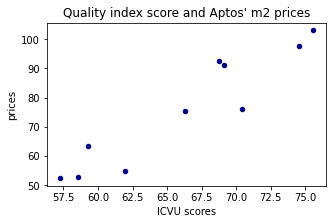

In [73]:
# taking a look to ICVU score and price relation
comunas_df.plot(kind='scatter', x='ICVU Score', y='m2 price', figsize=(5, 3), color='darkblue')

plt.title("Quality index score and Aptos' m2 prices")
plt.xlabel('ICVU scores')
plt.ylabel('prices')


Let's check the count of places in every Neighborhood.

In [20]:
santiago.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Pos.,Region,Province,Capital,latitude,longitude,ICVU Score,m2 price
Neighborhood,,,,,,,,,,,,,,
La Florida,24,24,24,24,24,24,24,24,24,24,24,24,24,24
La Reina,60,60,60,60,60,60,60,60,60,60,60,60,60,60
Las Condes,28,28,28,28,28,28,28,28,28,28,28,28,28,28
Lo Barnechea,100,100,100,100,100,100,100,100,100,100,100,100,100,100
Macul,86,86,86,86,86,86,86,86,86,86,86,86,86,86
Providencia,100,100,100,100,100,100,100,100,100,100,100,100,100,100
San Miguel,94,94,94,94,94,94,94,94,94,94,94,94,94,94
Santiago,99,99,99,99,99,99,99,99,99,99,99,99,99,99
Vitacura,100,100,100,100,100,100,100,100,100,100,100,100,100,100


We include the information of ICVU score and square meter's price to the features to be included into the model.

In [35]:
# Analizing each Neighborhood with one hot encoding
santiago_onehot = pd.get_dummies(santiago[['Venue Category']], prefix="", prefix_sep="")
# Variable with Neighborhood values (data)
data = santiago["Neighborhood"]
santiago_onehot.insert(0, "Neighborhood", data)
data2 = santiago["ICVU Score"] 
santiago_onehot.insert(1, "ICVU Score", data2)
data3 = santiago["m2 price"] 
santiago_onehot.insert(2, "m2 price", data3)
santiago_onehot = santiago_onehot.reset_index(drop=True)
santiago_onehot.head()

,Neighborhood,ICVU Score,m2 price,Accessories Store,Airport,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
0,Vitacura,75.59,103.1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Vitacura,75.59,103.1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Vitacura,75.59,103.1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Vitacura,75.59,103.1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Vitacura,75.59,103.1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
santiago_onehot.shape

(791, 187)

In [74]:
# Taking a look to the mean of the frequency of ocurrence of each Neighborhood (this will be used to calculate the distance to the centroids)
santiago_grouped = santiago_onehot.groupby("Neighborhood").mean().reset_index()
santiago_grouped.head(5)

,Neighborhood,ICVU Score,m2 price,Accessories Store,Airport,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Toy / Game Store,Trail,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Wine Bar,Wine Shop,Yoga Studio,Zoo Exhibit
0,La Florida,57.23,52.3,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000
1,La Reina,70.45,76.0,0.0,0.033333,0.016667,0.0,0.0,0.0,0.0,...,0.016667,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.016667
2,Las Condes,74.54,97.6,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.035714,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000
3,Lo Barnechea,69.09,91.3,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.000000
4,Macul,61.92,54.8,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.011628,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000


Exploring the number of venues in Santiago

In [24]:
len(Santiago_venues['Venue Category'].unique())

185

In [49]:
# Printing each Neighborhood with the top 5 most common venues
num_top_venues = 5

for hood in santiago_grouped["Neighborhood"]:
    print("----"+hood+"----")
    temp = santiago_grouped[santiago_grouped["Neighborhood"] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[3:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----La Florida----
                venue  freq
0                Park  0.12
1          Restaurant  0.08
2                 Gym  0.08
3  Seafood Restaurant  0.04
4      Scenic Lookout  0.04


----La Reina----
                venue  freq
0          Restaurant  0.07
1         Pizza Place  0.05
2    Sushi Restaurant  0.05
3  Chinese Restaurant  0.05
4               Plaza  0.03


----Las Condes----
            venue  freq
0    Soccer Field  0.14
1           Plaza  0.14
2       Racetrack  0.07
3            Park  0.07
4  Soccer Stadium  0.04


----Lo Barnechea----
           venue  freq
0            Gym  0.08
1     Restaurant  0.06
2    Coffee Shop  0.05
3  Shopping Mall  0.04
4       Pharmacy  0.04


----Macul----
                venue  freq
0  Chinese Restaurant  0.10
1          Restaurant  0.07
2        Soccer Field  0.06
3    Sushi Restaurant  0.05
4       Hot Dog Joint  0.05


----Providencia----
               venue  freq
0               Park  0.07
1        Coffee Shop  0.07
2            

In [53]:
# Transforming top venues into a dataframe: Writting a function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [75]:
# Transforming top venues into a dataframe: Running the function with top 5
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = santiago_grouped['Neighborhood']

for ind in np.arange(santiago_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(santiago_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,La Florida,Park,Gym,Restaurant,Big Box Store,Coffee Shop
1,La Reina,Restaurant,Pizza Place,Sushi Restaurant,Chinese Restaurant,Playground
2,Las Condes,Soccer Field,Plaza,Park,Racetrack,Pharmacy
3,Lo Barnechea,Gym,Restaurant,Coffee Shop,Sushi Restaurant,Pharmacy
4,Macul,Chinese Restaurant,Restaurant,Soccer Field,Hot Dog Joint,Sushi Restaurant
5,Providencia,Coffee Shop,Park,Hotel,French Restaurant,Ice Cream Shop
6,San Miguel,Sushi Restaurant,Pizza Place,Restaurant,Plaza,Park
7,Santiago,Coffee Shop,Café,Pizza Place,Hotel,Hostel
8,Vitacura,Café,Gym / Fitness Center,Restaurant,Bakery,Italian Restaurant
9,Ñuñoa,Coffee Shop,Bakery,Plaza,Restaurant,Pizza Place


## 5. Clustering model   <a name="Model"></a>

To determine the clusters of Neighborhoods in Santiago it will be applied the K-means model, more efficient than the Hierarchical and allows to define the number of optimal clusters.

This algorithm works iteratively to assign every explored object to a cluster (k) based on their features. Objects are grouped based on the similarity of their features.

Entries must be numeric values. Given that the values of the features to be analyzed do not have an order of importance, I will use one-hot encoding over the “Venue Category” feature.

To run the algorithm, we need the features which will work into the model and a k value. The model iterates around two steps: (1) to every row of the data set will be assigned a centroid, the nearest and randomly, based on the Euclidean distance. (2) The centroids will be updated, based on the measure of every point assigned in the last step. The distances will be updated, the rows of data are reassigned again, and the centroids recalculated until the error is minimized, it means the total distance (Distortions).


First step, is to normalize the features to be used.

In [55]:
# Normalizing over the standard deviation
X = santiago_grouped.copy()
X = X.values[:,1:]
X = np.nan_to_num(X)
dataset = StandardScaler().fit_transform(X)
dataset

array([[-1.4196397 , -1.27886296, -0.33333333, ..., -0.46852129,
        -0.65543701, -0.33333333],
       [ 0.67988338,  0.00433146, -0.33333333, ..., -0.46852129,
        -0.65543701,  3.        ],
       [ 1.32943326,  1.17382511, -0.33333333, ..., -0.46852129,
        -0.65543701, -0.33333333],
       ...,
       [-1.09565883, -0.67787317,  3.        , ..., -0.46852129,
         0.4461378 , -0.33333333],
       [ 1.49618812,  1.47161284, -0.33333333, ..., -0.46852129,
         0.43512205, -0.33333333],
       [ 0.01762837, -0.0335688 , -0.33333333, ...,  1.09321633,
         2.61624017, -0.33333333]])

Second step, is to find the optimal K through the Elbow model.

In [56]:
distortions = []
mapping = {}
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
    mapping[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / X.shape[0] 

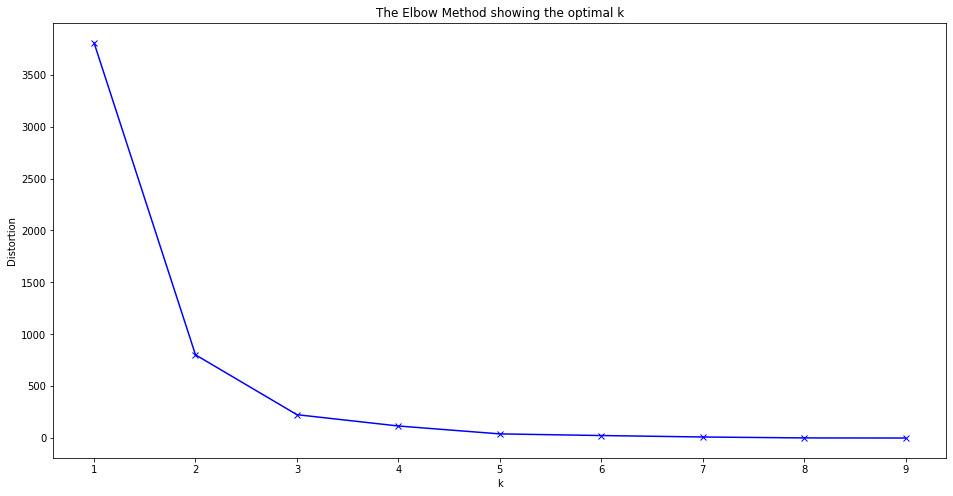

In [40]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Best K is 3.

With that information, we can run K-means to cluster the neighborhoods into 3.

In [57]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=3).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 1, 1, 0, 1, 0, 0, 1, 2])

The algorithm groups the Neighborhoods based on the Venues Cateories, ICVU score and m2 prices. 

Once we have the clusters, we add them to the dataframe.

In [58]:
# Add clusters labels to Dataframe
neighborhoods_venues_sorted2 = neighborhoods_venues_sorted.copy()
neighborhoods_venues_sorted2.insert(0, 'Cluster Labels', kmeans.labels_)

santiago_merged = comunas_df.copy()

# merge santiago_merged with df_Toronto_2 to add latitude/longitude for each neighborhood
santiago_merged = santiago_merged.merge(neighborhoods_venues_sorted2.set_index('Neighborhood'), on='Neighborhood')

santiago_merged.head()

,Pos.,Region,Province,Capital,Neighborhood,latitude,longitude,ICVU Score,m2 price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1,Metropolitana,Santiago,Santiago,Vitacura,-33.380206,-70.565795,75.59,103.1,1,Café,Gym / Fitness Center,Restaurant,Bakery,Italian Restaurant
1,2,Metropolitana,Santiago,Santiago,Las Condes,-33.424788,-70.517498,74.54,97.6,1,Soccer Field,Plaza,Park,Racetrack,Pharmacy
2,3,Metropolitana,Santiago,Santiago,La Reina,-33.447373,-70.533412,70.45,76.0,2,Restaurant,Pizza Place,Sushi Restaurant,Chinese Restaurant,Playground
3,4,Metropolitana,Santiago,Santiago,Lo Barnechea,-33.362323,-70.513423,69.09,91.3,1,Gym,Restaurant,Coffee Shop,Sushi Restaurant,Pharmacy
4,5,Metropolitana,Santiago,Santiago,Providencia,-33.428838,-70.611337,68.79,92.5,1,Coffee Shop,Park,Hotel,French Restaurant,Ice Cream Shop


In [59]:
# Getting the Coordinates of Santiago, Chile
address = 'Santiago, Chile'

geolocator = Nominatim(user_agent="stgo_explorer")
location = geolocator.geocode(address)
Latitude = location.latitude
Longitude = location.longitude
print('The geograpical coordinate of Santiago are {}, {}.'.format(Latitude, Longitude))

The geograpical coordinate of Santiago are -33.4377968, -70.6504451.


In [60]:
# Create the map
map_clusters = folium.Map(location=[Latitude, Longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(santiago_merged['latitude'], santiago_merged['longitude'], santiago_merged['Neighborhood'], santiago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

We examine the clusters to identify patterns if these exist.

In [61]:
#Cluster 1 (0)
santiago_merged.loc[santiago_merged["Cluster Labels"] == 0, santiago_merged.columns[[4] + list(range(7, santiago_merged.shape[1]))]]

,Neighborhood,ICVU Score,m2 price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,Macul,61.92,54.8,0,Chinese Restaurant,Restaurant,Soccer Field,Hot Dog Joint,Sushi Restaurant
7,Santiago,59.27,63.4,0,Coffee Shop,Café,Pizza Place,Hotel,Hostel
8,San Miguel,58.53,52.9,0,Sushi Restaurant,Pizza Place,Restaurant,Plaza,Park
9,La Florida,57.23,52.3,0,Park,Gym,Restaurant,Big Box Store,Coffee Shop


This is characterized by having the smaller m2 prices and ICVU scores. It also has many restaurants, coffee shop and hotels as venues in common.

In [62]:
#Cluster 2 (1)
santiago_merged.loc[santiago_merged["Cluster Labels"] == 1, santiago_merged.columns[[4] + list(range(7, santiago_merged.shape[1]))]]

,Neighborhood,ICVU Score,m2 price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Vitacura,75.59,103.1,1,Café,Gym / Fitness Center,Restaurant,Bakery,Italian Restaurant
1,Las Condes,74.54,97.6,1,Soccer Field,Plaza,Park,Racetrack,Pharmacy
3,Lo Barnechea,69.09,91.3,1,Gym,Restaurant,Coffee Shop,Sushi Restaurant,Pharmacy
4,Providencia,68.79,92.5,1,Coffee Shop,Park,Hotel,French Restaurant,Ice Cream Shop


This is characterized by having the higuest m2 prices and ICVU scores. It also has many coffee shop, gym, and parks as venues in common. It seams to be mor green.

In [63]:
#Cluster 3 (2)
santiago_merged.loc[santiago_merged["Cluster Labels"] == 2, santiago_merged.columns[[4] + list(range(7, santiago_merged.shape[1]))]]

,Neighborhood,ICVU Score,m2 price,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,La Reina,70.45,76.0,2,Restaurant,Pizza Place,Sushi Restaurant,Chinese Restaurant,Playground
5,Ñuñoa,66.28,75.3,2,Coffee Shop,Bakery,Plaza,Restaurant,Pizza Place


This is characterized by having intermediate m2 prices and ICVU scores. It also has many restaurants as venues in common.

The algorithm cluster the neighborhoods mainly about the ICVU score and m2 prices. Restaurant is the type of venue that repeat on the three clusters.

## 6. Results and discussion <a name="Results"></a>

The model indicates that there are three cluster of neighborhoods regarding three kind of features: "Venue category", "ICVU score" and "Square meter's price (m2 price)".

Exploring the data, we could see that those Neighborhoods which are more expensive, have more venues around (100, based on the Radius and limit specified). We could see as well that the higher the score, the higher the price is.
The cluster are as follows:

-	Cluster 1 (0): This groups the Neighborhoods with the lowest ICVU scores in the group defined and the lowest price by m2. This cluster has neighborhoods with Restaurants, Coffees and hotels as most in common places.
-	Cluster 2 (1): This group the Neighborhoods with the highest ICVU score and the highest prices by m2. You can find Coffee shops, Parks and Gym as the most common places.
-	Cluster 3 (2): This group the Neighborhoods with the intermediate ICVU score and prices by m2. You can find here Restaurants.

As we can see, the three clusters have in common the Restaurants, and its segmented mainly by the ICVU score and properties prices by m2. The ICVU include an evaluation about services and goods provision, both public and private. It gives a score regarding living places, sociocultural conditions, business environment, labor conditions, health and environment, connectivity, and mobility.

This result does not imply those clusters are perfect or that will not change in the future with more information that could be considered.

## 7. Conclusion <a name="Conclusion"></a>

The purpose of this project was to identify some clusters based on the top 10 Neighborhoods from Santiago city based on the ICVU score, to give some information about prices, quality life and venues around to foreign people thinking about moving to Santiago, Chile. By gathering information about the Neighborhoods, their ICVU score, apartments’ prices and exploring their venues’ category around from Foursquare, then I generated a complete data frame to be used for the model. Clustering of these Neighborhoods was performed to identify profiles of the Neighborhoods on Santiago.

Families, workers, or students could take decision based on the characteristics identified in every cluster.